# Topic Modeling


## 1 - Library Imports

In [124]:
%reset -f

# Import Os to get to the root directory
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

# Import own functions
from libraries import corpus
from libraries import pdf2text

##########################
# Import other libraries
##########################

# Data Manipulation
import re, numpy as np, pandas as pd

# Gensim Library for Topic Modeling
import gensim
from gensim import matutils, models
import gensim, spacy, logging, warnings
from gensim import corpora, models, similarities
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

# Data Visualizations
import matplotlib.pyplot as plt
%matplotlib notebook
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# Natural Language Processing libraries
import nltk as nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from nltk.stem.wordnet import WordNetLemmatizer
import string

import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable =['parser', 'ner'])
from pprint import pprint

import scipy.sparse
from collections import Counter

# other imports
import pickle
from importlib import reload
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## 2 - Data Preprocessing

In [126]:
# Retrieving the PDF files from white-paper folder and converting them to text
dataset = pdf2text.get_dataset()

In [127]:
dataset.keys()

dict_keys(['#metahash', '0x', 'abbccoin', 'aion', 'apollocurrency', 'ardor', 'ark', 'basicattentiontoken', 'bhpcoin', 'binancecoin', 'bitcoin', 'bitcoingold', 'bitshares', 'bittorrent', 'bytecoin', 'bytom', 'celernetwork', 'chainlink', 'cosmocoin', 'cosmos', 'crypto', 'cryptonex', 'dai', 'dash', 'decentraland', 'dent', 'digixdao', 'dogecoin', 'elastos', 'enjincoin', 'eos', 'ethereum', 'ethereumclassic', 'factom', 'fantom', 'gnosis', 'golem', 'gxchain', 'holo', 'horizen', 'hypercash', 'hyperion', 'icon', 'iexecrlc', 'inocoin', 'iota', 'japancontenttoken', 'komodo', 'latoken', 'lina', 'loopring', 'maidsafecoin', 'maker', 'metal', 'metaverseetp', 'mixin', 'monero', 'nano', 'nebulas', 'nem', 'nexo', 'nkn', 'obyte', 'omisego', 'ontology', 'orbs', 'particl', 'paxosstandardtoken', 'powerledger', 'pundix', 'ravencoin', 'riftoken', 'siacoin', 'singularitynet', 'skycoin', 'solve', 'status', 'steem', 'stellar', 'stratis', 'synthetixnetworktoken', 'tenx', 'tether', 'tezos', 'theta', 'thetafuel', '

In [128]:
#corpora segregated in terms of sentences 
corpora = corpus.makeCleanCorpus(dataset, lemmatize=True, removePunct=True, removeNums=True, makeSentences=True, removeURL=True, removeChar= True, stops=['\u200b'] )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: #metahash
Cleaning: 0x
Cleaning: abbccoin
Cleaning: aion
Cleaning: apollocurrency
Cleaning: ardor
Cleaning: ark


KeyboardInterrupt: 

In [ ]:
#Corpora not segregated with sentences
corpora_whole = corpus.makeCleanCorpus(dataset, lemmatize=True, removePunct=True, removeNums=True, makeSentences= False, removeURL=True, removeChar= True, stops=['\u200b'] )

In [139]:
#Our dictionary at the moment is in key: blockchain firms, value: list of text of whitepapers
#We change this to key: blockchain firms and value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [ ]:
#Combining then
data_combined = {key:[combine_text(value)] for (key, value) in corpora.items()}

In [ ]:
#Putting the text into pandas dataframe
import pandas as pd
pd.set_option('max_colwidth', 150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['whitepapers']
data_df = data_df.sort_index()

In [38]:
#Glancing into the dataframe; it is a dataframe with each row representing a document (blockchain whitepaper)
data_df.head(2)

,whitepapers
#metahash,yellow paper technical documentation version g...
0x,open protocol decentralize exchange blockchain...


In [39]:
#Pickling the data for future use. 
data_df.to_pickle('tmcorpus.pkl')

In [6]:
with open('tmcorpus.pkl', 'rb') as f:
    data_ready = pickle.load(f)

In [10]:
# tokenizing the entire corpus by word
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = data_df.whitepapers.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['yellow', 'paper', 'technical', 'documentation', 'version', 'gartenstrasse', 'yellow', 'paper', 'project', 'goal', 'technical', 'feature', 'test', 'methodology', 'test', 'building', 'nerk', 'test', 'bulk', 'transaction', 'verification', 'latency', 'test', 'nerk', 'failure', 'test', 'blockage', 'nerk', 'recovery', 'test', 'result', 'nerk', 'description', 'data', 'synchronization', 'subsystem', 'nerk', 'structure', 'nerk', 'topology', 'nerk', 'map', 'multiple', 'proof', 'voting', 'cryptography', 'block', 'structure', 'balance', 'model', 'transaction', 'protocol', 'feature', 'specialuse', 'address', 'nature', 'address', 'frozen', 'address', 'child', 'address', 'delegation', 'reward', 'distribution', 'strategy', 'risk', 'conclusion', 'data', 'storage', 'yellow', 'paper', 'decentralize', 'technology', 'boom', 'paradigm', 'address', 'key', 'issue', 'issue', 'trust', 'control', 'authority', 'scalability', 'reliability', 'thirdparty', 'involvement', 'platform', 'app', 'market', 'limited', 'ma

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## 3 - Methods Application

### Topic Modeling on Blockchain Whitepapers

At the document level, a useful ways to understand the text is by analysing its topics. Topic Modelling is the process of learning, recognising and extracting the topics across a collection of documents. This notebook tries to uncover topics from blockchain whitepapers that is relevant to Schungrat in-terms of investment dimensions.

The notebook explores some of the methods of Topic Modelling such as ***Non-negative Matrix Factorization*** & ***Latent Dirichlet Allocation*** to see which fits better. Rather than being conceptual or mathematical, this notebook offers an applied approach with comments for the codes.


Since the goal of this notebook is Topic Modelling, the text must be tokenized which means broken down to small pieces which here is words. We use scikit-learn's CountVectorizer technique where every row represents a different document and every column will represent a different word. 

At this moment, stop words are also removed thanks to CountVectorizer. Stop words are common words that seldom adds meaning or value to the text. 


In [130]:
#Creating corpus and dictionary for gensim
id2word = corpora.Dictionary(data_ready)
corpus_lda = [id2word.doc2bow(text) for text in data_ready]

In [29]:
print(id2word[1])

absence


In [144]:
#lda with countvectorizer
lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus_lda,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=21,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)


In [71]:
#creating a Dataframe of topics and words in it
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [73]:
get_lda_topics(lda_gensim, 6)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,token,user,blockchain,datum,transaction,node
1,user,unit,nerk,service,node,key
2,platform,asset,node,application,block,transaction
3,blockchain,token,token,oracle,nerk,block
4,nerk,blockchain,transaction,technology,account,bit
5,market,address,state,compute,time,hash
6,provide,chain,user,smart_contract,blockchain,note
7,service,transaction,protocol,provider,protocol,set
8,asset,datum,chain,development,consensus,input
9,transaction,review,order,trust,chain,proof


In [175]:
# Compute Perplexity
print('\nPerplexity: ', lda_gensim.log_perplexity(corpus_lda))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_gensim, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.550260320990744

Coherence Score:  0.38675269508721805


### Word Count and Importance of Topic keyword

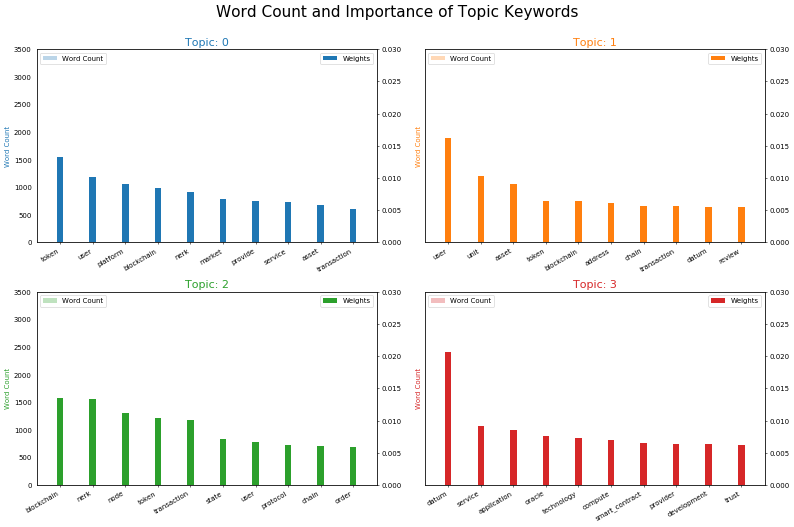

In [119]:
# Topics of the model
topics = lda_gensim.show_topics(formatted=False)

data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=50)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Dominant Topic and it's percentage contribution in the document

In [74]:
# Function that gets the Dominant Topic in a Document
def format_topics_sentences(ldamodel=None, corpus=corpus_lda, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_gensim, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9998,"transaction, node, block, nerk, account, time,...","[yellow_paper, technical, documentation, versi..."
1,1,2.0,0.9281,"blockchain, nerk, node, token, transaction, st...","[open, protocol, decentralize, exchange, block..."
2,2,0.0,0.9735,"token, user, platform, blockchain, nerk, marke...","[concept, reference, purpose, project, summary..."
3,3,0.0,0.3899,"token, user, platform, blockchain, nerk, marke...","[white_paper, enable, decentralize, internet, ..."
4,4,0.0,0.9472,"token, user, platform, blockchain, nerk, marke...","[ultimate, currency, privacy, mission, content..."
5,5,0.0,0.8637,"token, user, platform, blockchain, nerk, marke...","[jeluridawpicov, content, history, testimonial..."
6,6,2.0,0.9170,"blockchain, nerk, node, token, transaction, st...","[ecosystem, empower, aim, technical, backgroun..."
7,7,1.0,0.9789,"user, unit, asset, token, blockchain, address,...","[basic, attention, oftware, digital, advertisi..."
8,8,4.0,0.6736,"transaction, node, block, nerk, account, time,...","[distribute, payment, base, credit, payment, g..."
9,9,0.0,0.7929,"token, user, platform, blockchain, nerk, marke...","[exchange, intro, problem, exchange, match, en..."


### Most Discussed Topics in the Document

In [75]:
# Function that gets all the topics per document
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_gensim, corpus=corpus_lda, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_gensim.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

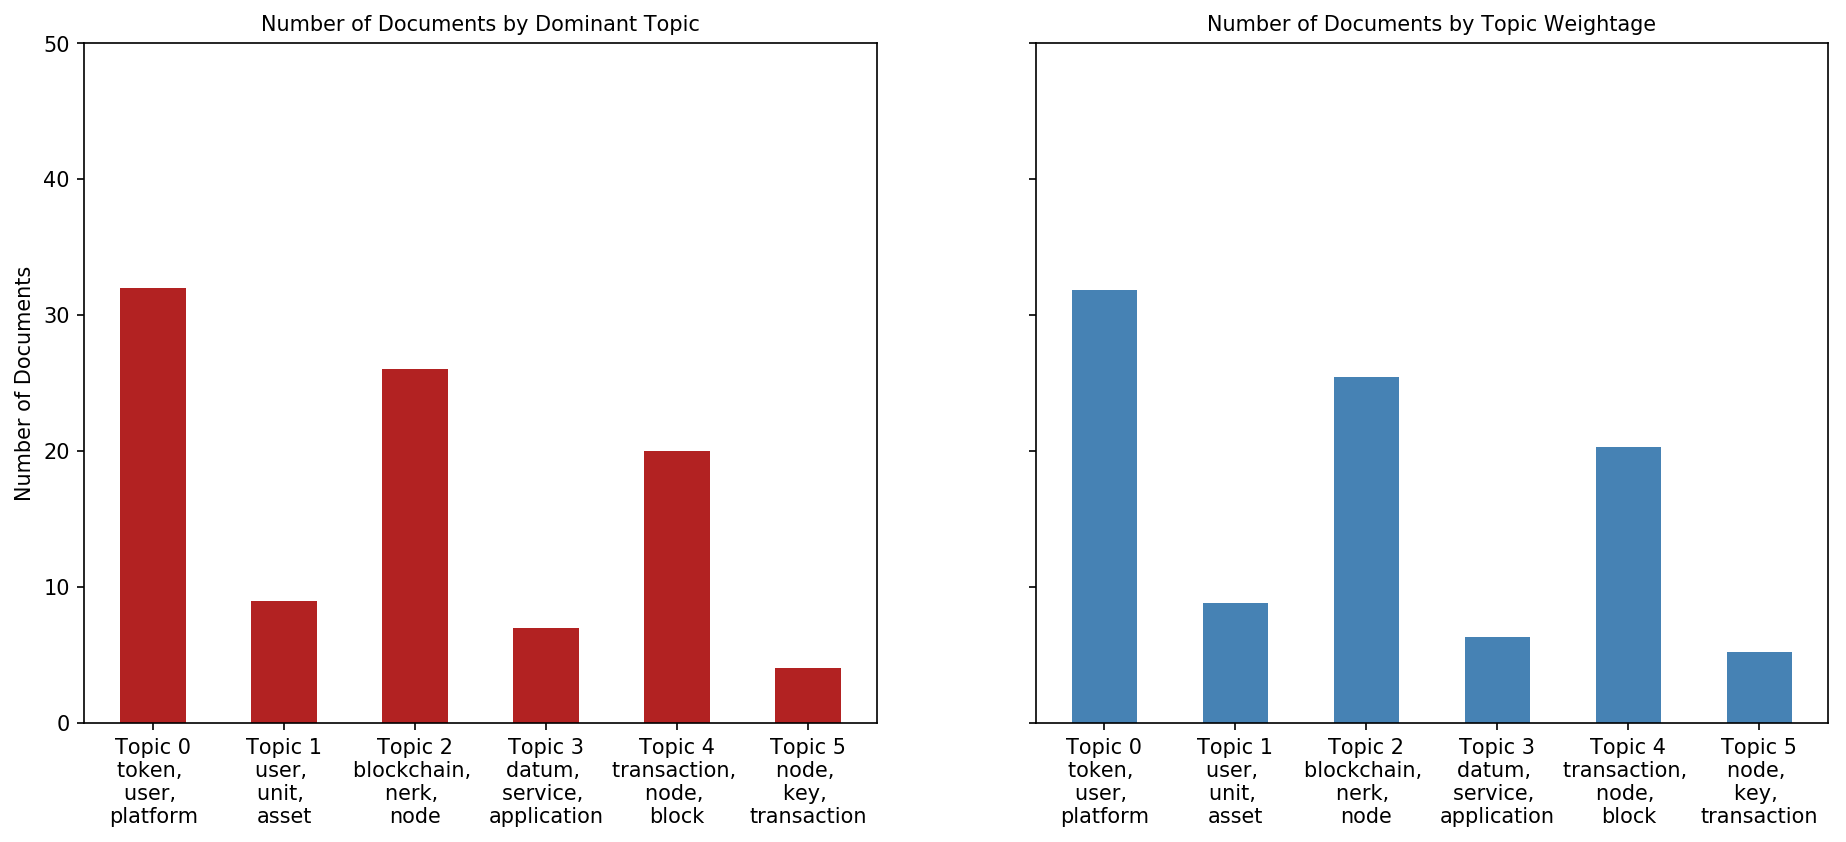

In [78]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=150, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 50)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [135]:
#saving the trained lda
trained = datapath("trained_lda")
lda_gensim.save(trained)
#loading the saved file
trained_lda = gensim.models.ldamodel.LdaModel.load(trained)

C:\Users\sj\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\sj\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\sj\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies

## 4 - Outcome 

### Input

In [136]:
TEST_DIR = os.path.join(ROOT_DIR, "test-white-papers")
testset = pdf2text.get_dataset(path=TEST_DIR)
testset.keys()

dict_keys(['adcoin', 'budbo', 'kwattcoin', 'oceanprotocol'])

In [131]:
#corpora segregated in terms of sentences 
corpora_test = corpus.makeCleanCorpus(testset, lemmatize=True, removePunct=True, removeNums=True, makeSentences=True, removeURL=True, removeChar= True, stops=['\u200b'] )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: adcoin
Cleaning: budbo
Cleaning: kwattcoin
Cleaning: oceanprotocol
Done!


In [137]:
#corpora segregated in terms of sentences 
corpora_test_whole = corpus.makeCleanCorpus(testset, lemmatize=True, removePunct=True, removeNums=True, makeSentences=False, removeURL=True, removeChar= True, stops=['\u200b'] )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: adcoin
Cleaning: budbo
Cleaning: kwattcoin
Cleaning: oceanprotocol
Done!


In [140]:
#Combining them and putting into pandas dataframe
test_combined = {key:[combine_text(value)] for (key, value) in corpora_test.items()}
pd.set_option('max_colwidth', 150)
test_df = pd.DataFrame.from_dict(test_combined).transpose()
test_df.columns = ['whitepapers']
test_df = test_df.sort_index()
test_df.head()

,whitepapers
adcoin,version offer lot great opportunity technological advancement adopt blockchain literally internet dominant cryptocurrency lot problem internet p...
budbo,global cannabis comehensive solution cannabis indtry version web wwwio content forward statement security la...
kwattcoin,newwhitepaper disclaimer document document constitute prospectus sort solicitation investment coin represent ownership share public private corp...
oceanprotocol,decentralize substrate service technical foundation ltd version apr paper decentralize protocol nerk artificial intelligence dataservices aim sp...


In [165]:
#creating the list and tokenizing each word in the test corpus
testdata = test_df.whitepapers.values.tolist()
testdata_words = list(sent_to_words(testdata))

In [ ]:
test_data_ready = process_words(testdata_words)

### Models/Methods

In [ ]:
corpus_lda_test = [id2word.doc2bow(text) for text in test_data_ready]

unseen_doc = other_corpus[0]
vector = lda_gensim[unseen_doc]  # get topic probability distribution for a document

In [197]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_gensim, corpus=corpus_lda_test, texts=test_data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,1.0,"advertising, payment, online, version, wallet, market, team, publisher, transaction, create","[version, offer, great, opportunity, adopt, blockchain, literally, internet, dominant, cryptocurrency, problem, internet, perform, payment, aim, i..."
1,1,0.0,1.0,"cannabis, token, business, platform, coin, global, blockchain, industry, inc, user","[global, cannabis, comehensive, solution, cannabis, indtry, version, web, wwwio, content, forward, statement, security, law, disclaimer, letter, k..."
2,2,0.0,1.0,"cannabis, token, business, platform, coin, global, blockchain, industry, inc, user","[newwhitepaper, disclaimer, document, document, sort, solicitation, investment, coin, represent, ownership, share, public, private, corporation, e..."
3,3,1.0,1.0,"datum, service, nerk, reward, access, token, data, stake, compute, publisher","[decentralize, substrate, service, technical, foundation, ltd, version, apr, paper, decentralize, protocol, nerk, dataservice, aim, spread, benefi..."


### Output

## 5 - Inspiration

- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/ 
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb
- https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
- https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
- https://medium.com/@tomar.ankur287/topic-modeling-using-lda-and-gibbs-sampling-explained-49d49b3d1045
- https://www.kdnuggets.com/2018/08/topic-modeling-lsa-plsa-lda-lda2vec.html
